In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

#SMOTE
from imblearn.over_sampling import SMOTE

#Drzewa
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

#Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns


# Wrangling

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/dane/motywacja.csv')

Mounted at /content/drive


In [3]:
#df=pd.read_csv('motywacja.csv')
#df.info()

In [4]:
#usunięcie kolumny 'Sygnatura czasowa'
df.drop('Sygnatura czasowa', axis=1, inplace=True)
#Usunięcie niepotrzebnych kolumn w analizie
df.drop(df.columns[1:10], axis=1, inplace=True)
#Zmiana nazwy kolumny Płeć
df = df.rename(columns={'Podaj płeć ': 'Płeć'})

# Drzewa + SMOT

## Zbiór Treningowy i Testowy

In [5]:
df_kobiety = df[df['Płeć'] == 'Kobieta'].sample(100,replace=False)
df_mezczyzni = df[df['Płeć'] == 'Mężczyzna'].sample(100,replace=False)
df_test_100k_m = pd.concat([df_kobiety, df_mezczyzni])

print(f'Wymiary ramki df przed usunięciem {df.shape}')
indeksy_do_skasowania = df_test_100k_m.index
df=df.drop(indeksy_do_skasowania)
df = df.reset_index(drop=True)
print(f'Wymiary ramki df po usunięciu {df.shape}')

print(f'Rozmiar próbki')
print(df_test_100k_m['Płeć'].value_counts())
df_test_100k_m = df_test_100k_m.sample(frac=1).reset_index(drop=True)

Wymiary ramki df przed usunięciem (14124, 45)
Wymiary ramki df po usunięciu (13924, 45)
Rozmiar próbki
Kobieta      100
Mężczyzna    100
Name: Płeć, dtype: int64


In [6]:
#Trening
X_train = df.drop('Płeć', axis=1)
y_train = df['Płeć']
#Test
X_test = df_test_100k_m.drop('Płeć', axis=1)
y_test = df_test_100k_m['Płeć']

## Drzewo - model wyjściowy

In [7]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train, y_train)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.545
F1: 0.5133559720848151
Macierz pomyłek: 
[[80 20]
 [71 29]]
Precyzja dla kobiet: 0.5298013245033113
Czułość dla kobiet: 0.8
F1 dla kobiet: 0.6374501992031872
Precyzja dla mężczyzn: 0.5918367346938775
Czułość dla mężczyzn: 0.29
F1 dla mężczyzn: 0.3892617449664429


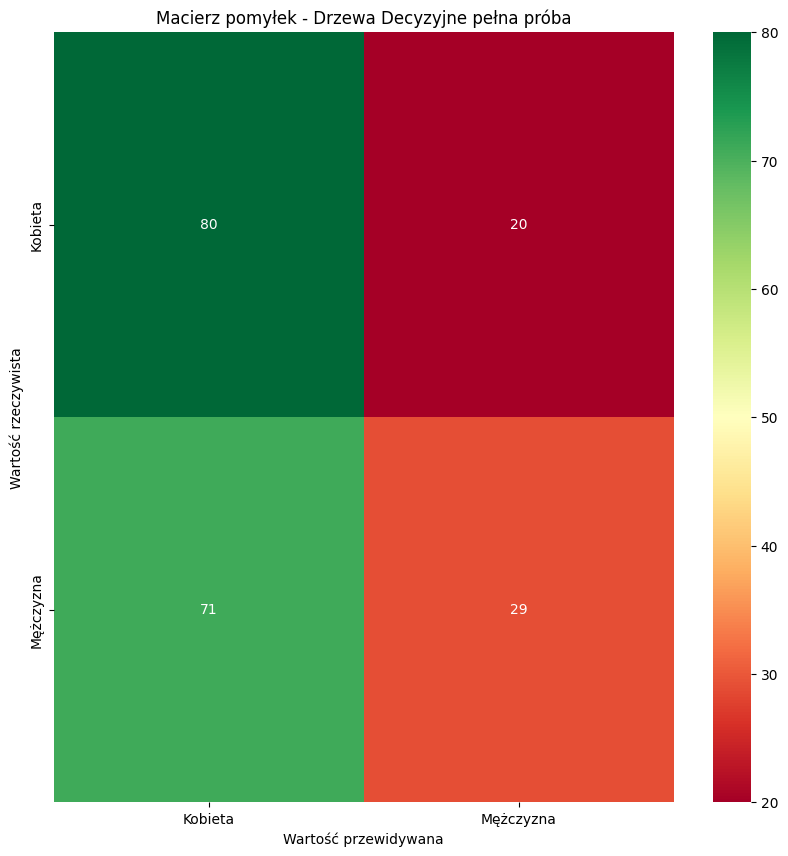

In [8]:
tytul_wykresu='Drzewa Decyzyjne pełna próba'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# SMOTH

In [9]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [10]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_smote, y_train_smote)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.555
F1: 0.5467393241832396
Macierz pomyłek: 
[[69 31]
 [58 42]]
Precyzja dla kobiet: 0.5433070866141733
Czułość dla kobiet: 0.69
F1 dla kobiet: 0.6079295154185023
Precyzja dla mężczyzn: 0.5753424657534246
Czułość dla mężczyzn: 0.42
F1 dla mężczyzn: 0.48554913294797686


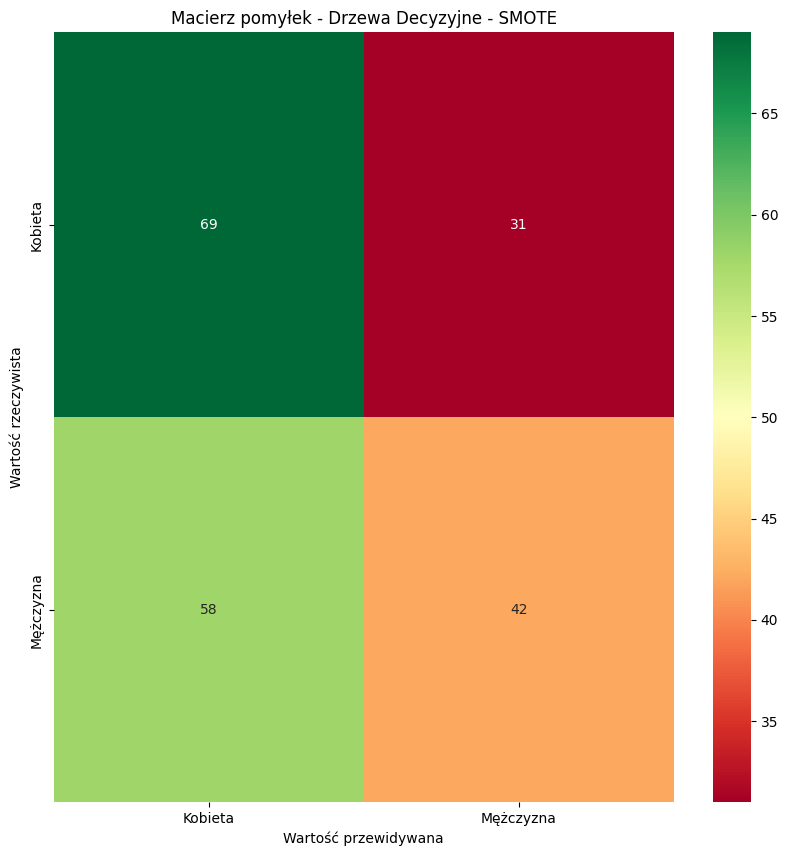

In [11]:
tytul_wykresu='Drzewa Decyzyjne - SMOTE'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

## Zmniejszenie klasy kobiet

In [12]:
df_2500=df.copy()
df_kobiety_2500 = df_2500[df_2500['Płeć'] == 'Kobieta'].sample(2500,replace=False)
df_mezczyzni_2500 = df_2500[df_2500['Płeć'] == 'Mężczyzna'].sample(2500,replace=False)
df_2500 = pd.concat([df_kobiety_2500, df_mezczyzni_2500])
df_2500 = df_2500.sample(frac=1).reset_index(drop=True)
df_2500

,Płeć,Akcje/obligacje/udziały w zyskach firmy,Bilety na imprezy kulturalne i sportowe,Bony towarowe,Ciekawa i urozmaicona praca,Darmowy bufet firmowy,Dobra atmosfera w miejscu pracy,Docenianie działań przez przełożonych,Dodatkowe ubezpieczenie na życie,Dodatkowe ubezpieczenie zdrowotne,...,"Szkolenia, studia, kursy",Telefon służbowy,"Udział, bądź realizacja ambitnych zadań, celów i projektów",Wyjazdy i imprezy integracyjne,Wysokość płacy zasadniczej,Zagrożenie przeniesienia na gorsze stanowisko,Zagrożenie utratą pracy,Znikomy poziom stresu,Zniżki na produkty i usługi firmowe,Zwrot za dojazdy do miejsca pracy
0,Mężczyzna,6,4,5,9,7,10,10,9,9,...,5,2,8,5,8,3,3,8,3,10
1,Kobieta,3,6,7,10,6,10,10,10,10,...,9,3,7,4,10,6,5,10,5,6
2,Kobieta,4,4,5,8,1,10,10,8,8,...,6,1,7,6,10,2,1,9,5,5
3,Mężczyzna,5,6,3,9,3,9,9,2,4,...,10,5,7,8,10,2,2,2,1,5
4,Kobieta,5,10,10,10,3,5,10,7,7,...,10,5,6,10,10,6,7,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Kobieta,4,4,4,5,2,7,8,5,5,...,3,3,4,3,6,4,7,8,5,4
4996,Mężczyzna,10,1,1,1,1,4,1,10,10,...,1,1,1,1,10,1,1,5,1,4
4997,Mężczyzna,5,5,1,6,5,9,9,8,8,...,5,7,7,9,8,1,5,5,1,5
4998,Mężczyzna,8,5,8,10,5,10,10,4,2,...,9,8,8,6,10,1,1,6,5,10


In [13]:
X_train_2500 = df_2500.drop('Płeć', axis=1)
y_train_2500= df_2500['Płeć']

In [14]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_2500, y_train_2500)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.55
F1: 0.5498199279711885
Macierz pomyłek: 
[[53 47]
 [43 57]]
Precyzja dla kobiet: 0.5520833333333334
Czułość dla kobiet: 0.53
F1 dla kobiet: 0.5408163265306124
Precyzja dla mężczyzn: 0.5480769230769231
Czułość dla mężczyzn: 0.57
F1 dla mężczyzn: 0.5588235294117646


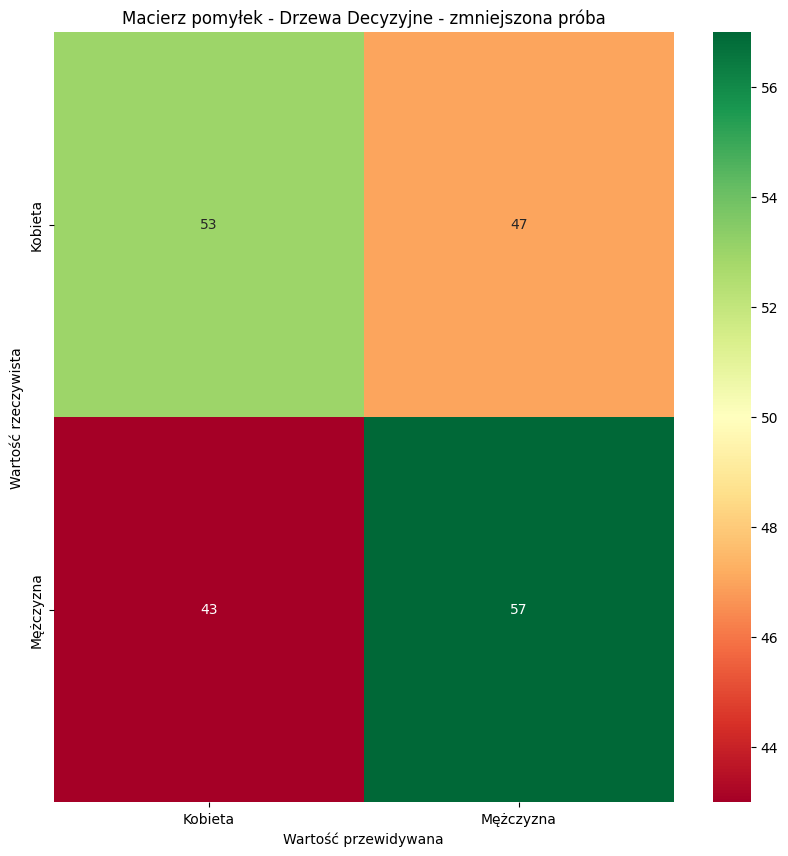

In [15]:
tytul_wykresu='Drzewa Decyzyjne - zmniejszona próba'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# Bootstrap

In [16]:
bootstrap_proba=100_000
df_bootstrap=pd.DataFrame()
df_bootstrap_kobiety=df[df['Płeć'] == 'Kobieta'].sample(bootstrap_proba,replace=True)
df_bootstrap_mezczyzni=df[df['Płeć'] == 'Mężczyzna'].sample(bootstrap_proba,replace=True)
df_bootstrap=pd.concat([df_bootstrap_kobiety, df_bootstrap_mezczyzni])
df_bootstrap = df_bootstrap.sample(frac=1).reset_index(drop=True)

In [17]:
X_train_bootstrap = df_bootstrap.drop('Płeć', axis=1)
y_train_bootstrap = df_bootstrap['Płeć']

In [18]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_bootstrap, y_train_bootstrap)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.51
F1: 0.4683159722222222
Macierz pomyłek: 
[[79 21]
 [77 23]]
Precyzja dla kobiet: 0.5064102564102564
Czułość dla kobiet: 0.79
F1 dla kobiet: 0.6171875
Precyzja dla mężczyzn: 0.5227272727272727
Czułość dla mężczyzn: 0.23
F1 dla mężczyzn: 0.3194444444444445


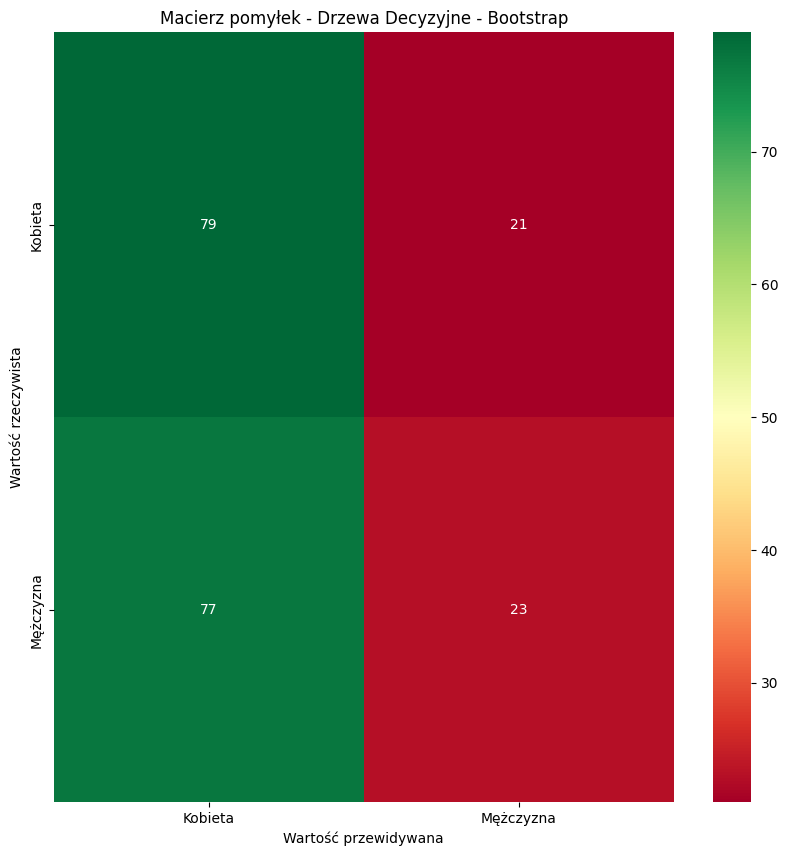

In [19]:
tytul_wykresu='Drzewa Decyzyjne - Bootstrap'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

In [20]:
df_bootstrap.value_counts('Płeć')

Płeć
Kobieta      100000
Mężczyzna    100000
dtype: int64

# Szukanie hiperparametrów

In [21]:
model = DecisionTreeClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')


hiperparametry = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)


random_search.fit(X_train_2500, y_train_2500)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')


Najlepsze parametry: {'criterion': 'gini', 'max_depth': 3, 'max_features': 22, 'min_samples_leaf': 18, 'min_samples_split': 15, 'splitter': 'random'}
Dokładność modelu: 0.61
F1: 0.6096486838154338
Macierz pomyłek: 
[[64 36]
 [42 58]]
Precyzja dla kobiet: 0.6037735849056604
Czułość dla kobiet: 0.64
F1 dla kobiet: 0.6213592233009708
Precyzja dla mężczyzn: 0.6170212765957447
Czułość dla mężczyzn: 0.58
F1 dla mężczyzn: 0.5979381443298969


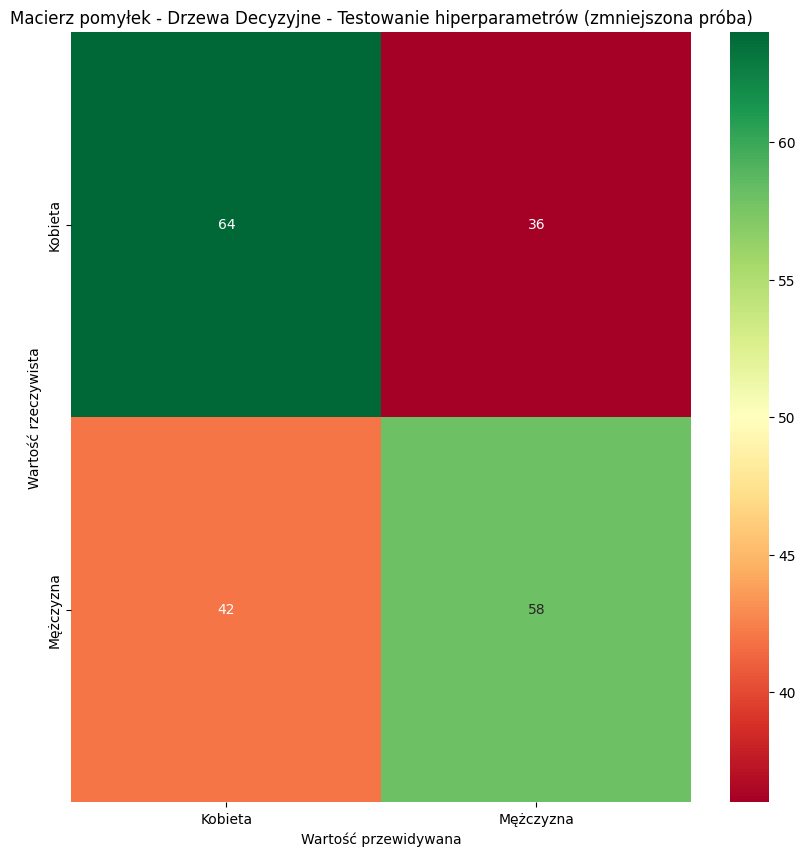

In [22]:
tytul_wykresu='Drzewa Decyzyjne - Testowanie hiperparametrów (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# Random Forest

musiałem zmniejszyć liczbe literacji oraz poziom kroswalidacji z powodu złożoności obliczeniowej.

In [23]:
model = RandomForestClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

hiperparametry = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_2500, y_train_2500)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 17, 'max_features': 14, 'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 126}
Dokładność modelu: 0.65
F1: 0.6496847162446201
Macierz pomyłek: 
[[68 32]
 [38 62]]
Precyzja dla kobiet: 0.6415094339622641
Czułość dla kobiet: 0.68
F1 dla kobiet: 0.6601941747572816
Precyzja dla mężczyzn: 0.6595744680851063
Czułość dla mężczyzn: 0.62
F1 dla mężczyzn: 0.6391752577319586


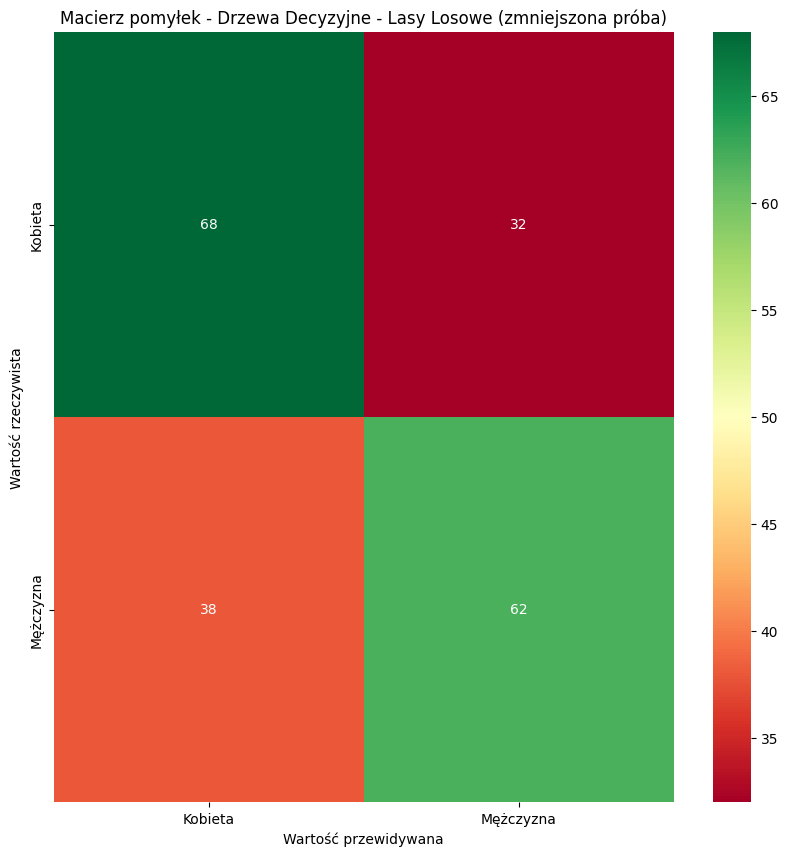

In [24]:
tytul_wykresu='Drzewa Decyzyjne - Lasy Losowe (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# XGBoost

In [25]:
model = XGBClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

#Trzeba tu zakodować klasy
y_train_2500_le=y_train_2500.map({'Kobieta': 0, 'Mężczyzna': 1})
y_test_le=y_test.map({'Kobieta': 0, 'Mężczyzna': 1})


hiperparametry = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [1, 2, 5, 10],
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'max_delta_step': randint(1, 10),
    'min_split_loss': [0, 0.1, 0.2, 0.5, 1],
    'colsample_bylevel': uniform(0.5, 1.0),
    'colsample_bynode': uniform(0.5, 1.0),
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'booster': ['gbtree', 'gblinear', 'dart'],
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_2500, y_train_2500_le)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test_le, predykcje)
c_m = confusion_matrix(y_test_le, predykcje)
f1 = f1_score(y_test_le, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test_le, predykcje, pos_label=0)
czulosc_kobieta = recall_score(y_test_le, predykcje, pos_label=0)
f1_kobieta = f1_score(y_test_le, predykcje, pos_label=0)

precyzja_mezczyzna = precision_score(y_test_le, predykcje, pos_label=1)
czulosc_mezczyzna = recall_score(y_test_le, predykcje, pos_label=1)
f1_mezczyzna = f1_score(y_test_le, predykcje, pos_label=1)

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
 

Najlepsze parametry: {'booster': 'gbtree', 'colsample_bylevel': 0.5878664991448334, 'colsample_bynode': 0.8506269312091808, 'colsample_bytree': 0.5332031087913666, 'gamma': 0.07857849715502074, 'learning_rate': 0.1290769828604788, 'max_delta_step': 2, 'max_depth': 6, 'min_child_weight': 7, 'min_split_loss': 0.1, 'n_estimators': 183, 'reg_alpha': 0.6931939408226809, 'reg_lambda': 0.8214407280098664, 'scale_pos_weight': 2, 'subsample': 0.6674825822590698, 'tree_method': 'auto'}
Dokładność modelu: 0.665
F1: 0.6587812889918769
Macierz pomyłek: 
[[53 47]
 [20 80]]
Precyzja dla kobiet: 0.726027397260274
Czułość dla kobiet: 0.53
F1 dla kobiet: 0.6127167630057804
Precyzja dla mężczyzn: 0.6299212598425197
Czułość dla mężczyzn: 0.8
F1 dla mężczyzn: 0.7048458149779735


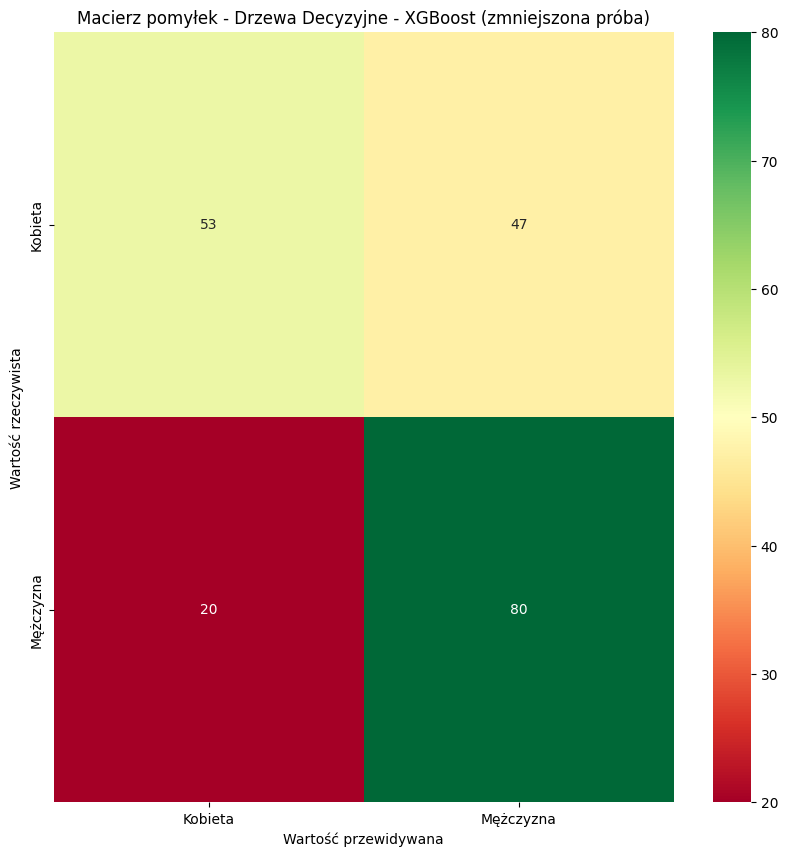

In [26]:
tytul_wykresu='Drzewa Decyzyjne - XGBoost (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# SMOTE


## Testowanie hiperparametrów

In [27]:
model = DecisionTreeClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')


hiperparametry = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)


random_search.fit(X_train_smote, y_train_smote)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')


Najlepsze parametry: {'criterion': 'gini', 'max_depth': 12, 'max_features': 36, 'min_samples_leaf': 2, 'min_samples_split': 4, 'splitter': 'best'}
Dokładność modelu: 0.585
F1: 0.576087234096887
Macierz pomyłek: 
[[73 27]
 [56 44]]
Precyzja dla kobiet: 0.5658914728682171
Czułość dla kobiet: 0.73
F1 dla kobiet: 0.6375545851528384
Precyzja dla mężczyzn: 0.6197183098591549
Czułość dla mężczyzn: 0.44
F1 dla mężczyzn: 0.5146198830409356


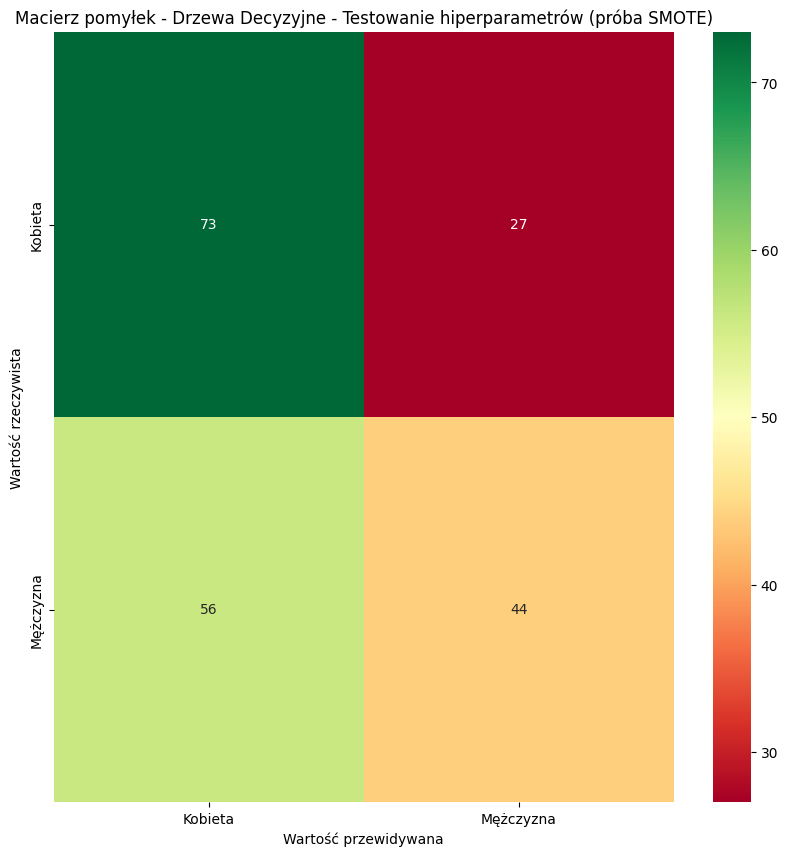

In [28]:
tytul_wykresu='Drzewa Decyzyjne - Testowanie hiperparametrów (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

## Lasy losowe - SMOT

In [29]:
model = RandomForestClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

hiperparametry = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_smote, y_train_smote)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 18, 'max_features': 37, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 143}
Dokładność modelu: 0.575
F1: 0.554402243715761
Macierz pomyłek: 
[[79 21]
 [64 36]]
Precyzja dla kobiet: 0.5524475524475524
Czułość dla kobiet: 0.79
F1 dla kobiet: 0.6502057613168724
Precyzja dla mężczyzn: 0.631578947368421
Czułość dla mężczyzn: 0.36
F1 dla mężczyzn: 0.45859872611464964


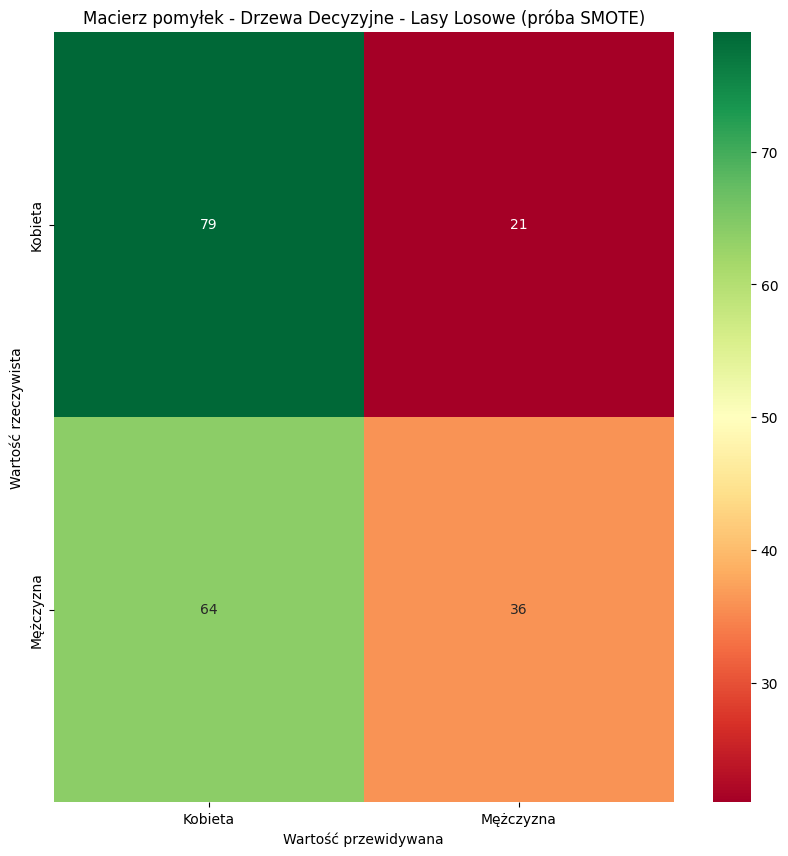

In [30]:
tytul_wykresu='Drzewa Decyzyjne - Lasy Losowe (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# XGB - SMOTE

In [31]:
model = XGBClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

#Trzeba tu zakodować klasy
y_train_smote_le=y_train_smote.map({'Kobieta': 0, 'Mężczyzna': 1})
y_test_le=y_test.map({'Kobieta': 0, 'Mężczyzna': 1})

(X_train_smote, y_train_smote)
hiperparametry = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [1, 2, 5, 10],
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'max_delta_step': randint(1, 10),
    'min_split_loss': [0, 0.1, 0.2, 0.5, 1],
    'colsample_bylevel': uniform(0.5, 1.0),
    'colsample_bynode': uniform(0.5, 1.0),
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'booster': ['gbtree', 'gblinear', 'dart'],
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_smote, y_train_smote_le)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test_le, predykcje)
c_m = confusion_matrix(y_test_le, predykcje)
f1 = f1_score(y_test_le, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test_le, predykcje, pos_label=0)
czulosc_kobieta = recall_score(y_test_le, predykcje, pos_label=0)
f1_kobieta = f1_score(y_test_le, predykcje, pos_label=0)

precyzja_mezczyzna = precision_score(y_test_le, predykcje, pos_label=1)
czulosc_mezczyzna = recall_score(y_test_le, predykcje, pos_label=1)
f1_mezczyzna = f1_score(y_test_le, predykcje, pos_label=1)

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
 

Najlepsze parametry: {'booster': 'gbtree', 'colsample_bylevel': 0.5046320230046029, 'colsample_bynode': 0.8334991716911442, 'colsample_bytree': 0.8981686935909433, 'gamma': 0.5373956029379229, 'learning_rate': 0.28595668492382814, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 2, 'min_split_loss': 0.2, 'n_estimators': 171, 'reg_alpha': 0.9184547249393011, 'reg_lambda': 0.5870682241365672, 'scale_pos_weight': 5, 'subsample': 0.9524395161326934, 'tree_method': 'approx'}
Dokładność modelu: 0.615
F1: 0.6042250263421654
Macierz pomyłek: 
[[78 22]
 [55 45]]
Precyzja dla kobiet: 0.5864661654135338
Czułość dla kobiet: 0.78
F1 dla kobiet: 0.669527896995708
Precyzja dla mężczyzn: 0.6716417910447762
Czułość dla mężczyzn: 0.45
F1 dla mężczyzn: 0.5389221556886228


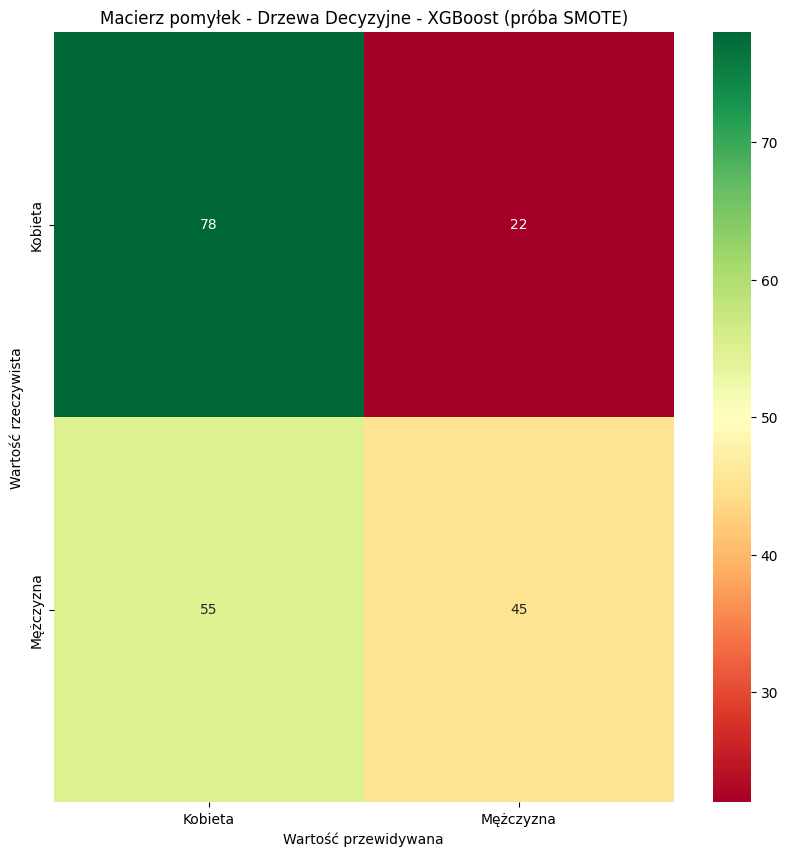

In [32]:
tytul_wykresu='Drzewa Decyzyjne - XGBoost (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

In [33]:
!cp * '/content/drive/MyDrive/dane/'

cp: -r not specified; omitting directory 'drive'
cp: -r not specified; omitting directory 'sample_data'
